In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'random/'
features = 'orbsummaryfeaturesxgbNorbits10000.0Nout1729window10/'
dataset = pd.read_csv(datapath+dset+features+'trainingdata.csv', index_col = 0)
print(dataset.columns.values)

['t_final_short' 'avg_beta12' 'std_beta12' 'min_beta12' 'max_beta12'
 'avg_beta23' 'std_beta23' 'min_beta23' 'max_beta23' 'avg_a1' 'std_a1'
 'max_a1' 'min_a1' 'norm_std_a1' 'norm_max_a1' 'norm_std_window10_a1'
 'norm_max_window10_a1' 'avg_e1' 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1'
 'norm_max_e1' 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1'
 'std_inc1' 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window10_inc2' 'avg_eH2' 'std_eH2' '

In [3]:
labels = pd.read_csv(datapath+dset+features+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
24995,0024995.bin,1.843086e+04,5.927632e+04,False
24996,0024996.bin,1.868259e+03,2.336571e+03,False
24997,0024997.bin,6.939732e+04,1.870889e+04,False
24998,0024998.bin,3.230628e+04,2.883785e+04,False
24999,0024999.bin,1.000024e+09,1.000024e+09,True


In [4]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = labels['Stable']
X = dataset[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,norm_a2_slope,norm_a3_slope,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23
0,0.396213,0.478865,0.000388,0.001293,0.000336,0.000583,0.000832,0.002551,0.000745,0.001293,...,-1.657231e-12,4.849073e-12,8.483517,0.057098,8.303471,8.556362,15.793710,0.092834,15.575529,16.123424
1,1.046322,0.837912,0.000710,0.002449,0.000075,0.000136,0.000197,0.000389,0.000127,0.000252,...,5.754337e-13,-3.581334e-13,8.422873,0.038531,8.290490,8.538080,15.313540,0.036489,15.247157,15.373060
2,2.406573,3.180981,0.279397,1.457620,0.001837,0.002460,0.088457,0.216404,0.002200,0.002950,...,-1.599032e-08,-1.451188e-09,-2.642935,5.740286,-19.721570,5.291956,30.871959,5.520858,21.075916,49.209307
3,0.435315,0.557820,0.000025,0.000120,0.000030,0.000086,0.000017,0.000048,0.000016,0.000028,...,-3.538088e-14,1.594421e-13,18.513730,0.003400,18.498146,18.522660,19.142632,0.008431,19.121812,19.158502
4,5.441820,3.714162,0.005532,0.022189,0.000108,0.000250,0.016743,0.043827,0.001022,0.001952,...,-9.065128e-10,-7.748364e-11,4.212652,3.453793,-3.047322,11.449205,3.808669,2.215113,-1.086974,10.230262


In [5]:
X.shape

(25000, 37)

In [6]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
xgbc = XGBClassifier(seed = 0)

In [7]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [8]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9330268399999999                                  
ERROR                                               
0.0020934351487389685                               
HOLDOUT SCORE                                       
0.957689703435249                                   
SCORE:                                                                        
0.9689474200000001                                                            
ERROR                                                                         
0.0013653854515694053                                                         
HOLDOUT SCORE                                                                 
0.9772007186950353                                                            
SCORE:                                                                        
0.94653844                                                                    
ERROR                                             

ERROR                                                                           
0.0014987357561907924                                                           
HOLDOUT SCORE                                                                   
0.9806395367054405                                                              
SCORE:                                                                          
0.9725888799999998                                                              
ERROR                                                                           
0.0029549351779127203                                                           
HOLDOUT SCORE                                                                   
0.9808675010334216                                                              
SCORE:                                                                          
0.9726254200000002                                                              
ERROR                       

0.9692089599999999                                                              
ERROR                                                                           
0.0011437061549712762                                                           
HOLDOUT SCORE                                                                   
0.9781749918189206                                                              
SCORE:                                                                          
0.9737875800000001                                                              
ERROR                                                                           
0.002167936283294354                                                            
HOLDOUT SCORE                                                                   
0.9811138130967307                                                              
SCORE:                                                                          
0.9732056399999998          

In [10]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.19992443612298202,
 'x_max_depth': 8,
 'x_min_child': 4.0,
 'x_pos_weight': 13.207393711632005,
 'x_subsample': 0.9473746850240131,
 'x_tree_colsample': 0.6492071813103917}

In [11]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.961171+0.00348308	test-auc:0.95165+0.00596991
[1]	train-auc:0.968936+0.0047304	test-auc:0.959641+0.00413912
[2]	train-auc:0.975837+0.0020587	test-auc:0.965907+0.00165787
[3]	train-auc:0.978713+0.00224813	test-auc:0.968551+0.00187478
[4]	train-auc:0.981622+0.00107196	test-auc:0.971199+0.00189505
[5]	train-auc:0.983599+0.000678936	test-auc:0.972891+0.00207625
[6]	train-auc:0.984884+0.000766212	test-auc:0.973719+0.00214655
[7]	train-auc:0.986018+0.00108639	test-auc:0.974551+0.0021659
[8]	train-auc:0.987184+0.000822133	test-auc:0.975047+0.00227281
[9]	train-auc:0.988116+0.000747782	test-auc:0.975696+0.00246967
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.961171       0.003483       0.951650      0.005970
1        0.968936       0.004730       0.959641      0.004139
2        0.975837       0.002059       0.965907      0.001658
3        0.978713       0.002248       0.968551      0.001875
4        0.981622       0.001072       0.971199      0.00189

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.9680352991986687


In [12]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.9853751793512072
0.9774309130414959


In [13]:
print(best)

{'x_learning_rate': 0.19992443612298202, 'x_max_depth': 8, 'x_min_child': 4.0, 'x_pos_weight': 13.207393711632005, 'x_subsample': 0.9473746850240131, 'x_tree_colsample': 0.6492071813103917}


Text(0.5, 1.0, 'ROC curve (AUC = 0.985)')

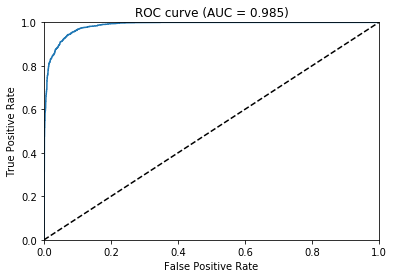

In [14]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [15]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.002101781079545617, recall = 1.0, precision = 0.6519867549668874
Threshold 0.0022292498033493757, recall = 0.9994921279837481, precision = 0.6549084858569052
Threshold 0.0023890486918389797, recall = 0.9989842559674962, precision = 0.6578595317725753
Threshold 0.0025237181689590216, recall = 0.9989842559674962, precision = 0.6611764705882353
Threshold 0.002782845636829734, recall = 0.9989842559674962, precision = 0.664527027027027
Threshold 0.0030726008117198944, recall = 0.9989842559674962, precision = 0.6679117147707979
Threshold 0.0033367990981787443, recall = 0.9989842559674962, precision = 0.6713310580204778
Threshold 0.0035839020274579525, recall = 0.9989842559674962, precision = 0.6747855917667238
Threshold 0.0040121907368302345, recall = 0.9989842559674962, precision = 0.6782758620689655
Threshold 0.004262341186404228, recall = 0.9989842559674962, precision = 0.6818024263431542
Threshold 0.00460251746699214, recall = 0.9989842559674962, precision = 0.685365853658536

AUC Score (Test): 0.977431


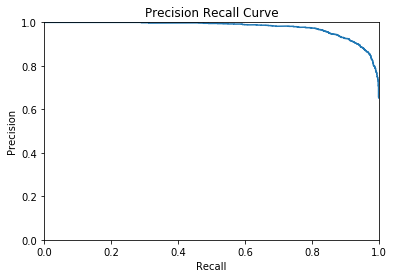

In [16]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.9993923  0.99996924 0.05746656 0.9999211  0.9998363 ]
1969 3031
[2343.   88.   57.   36.   22.   14.   17.   19.   15.    9.   18.    6.
   12.    8.    4.   10.    5.   10.    7.    8.    5.   17.   10.    8.
    4.    6.    8.    8.    5.    7.    3.    3.    7.    8.    9.    7.
    4.    8.    5.    4.    6.   10.   14.   13.    9.   20.   21.   24.
   31.   39.]
[  6   6   7   5   4   4   1   2   1   2   5   1   1   1   1   1   1   2
   1   4   4   7   6   3   4   3   3   2   6   4   2   6   2   2   5   4
   4   9   8   2   4  11  16  13  20  30  43  37  95 986]


(0, 350)

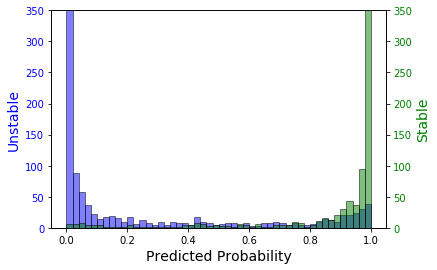

In [17]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

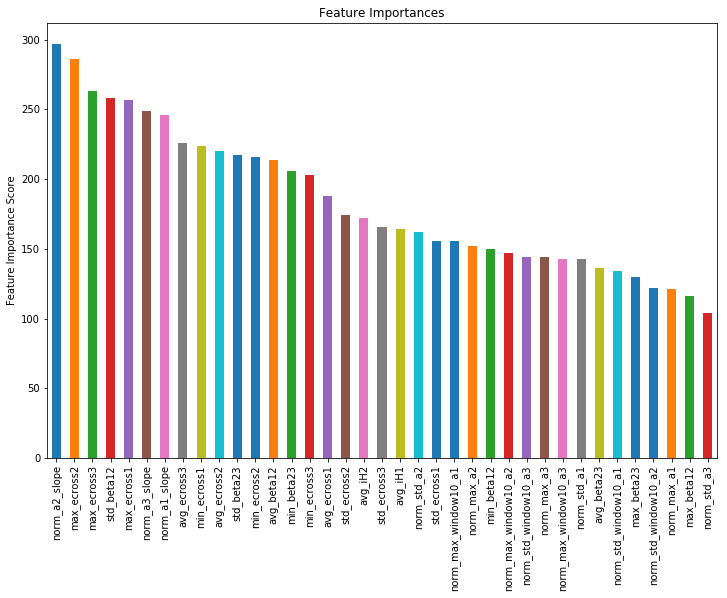

In [18]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [19]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/orbsummaryfeaturesxgb_random.pkl", "wb"))